In [1]:
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense

/home/dex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [3]:
nTrain = x_train.shape[0]
nVal = y_test.shape[0]
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
val_features = np.zeros(shape=(nVal, 7, 7, 512))
train_labels = np.zeros(shape=10)

In [5]:
from  skimage import transform

new_shape = (48,48,3)
x_train = np.asarray([transform.resize(image, new_shape) for image in x_train]) 
x_test  = np.asarray([transform.resize(image, new_shape) for image in x_test ])

/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

In [6]:
add_model = Sequential()
add_model.add(Flatten(input_shape = vgg_conv.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
#add_model.add(Dense(1024, activation='relu'))
add_model.add(Dense(10, activation='sigmoid'))

model = Model(inputs=vgg_conv.input, outputs=add_model(vgg_conv.output))
model.compile(loss='binary_crossentropy', optimizer = optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [9]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [ lr_reducer, PlotLossesKeras()]

In [11]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [14]:
y_train.shape, x_test.shape, x_test.shape, y_test.shape

((50000, 10), (10000, 48, 48, 3), (10000, 48, 48, 3), (10000, 10))

In [21]:
for i in datagen.flow(x_train, y_train, batch_size=batch_size):
    print (type(i), i[0].shape, i[1].shape)
    break

<class 'tuple'> (32, 48, 48, 3) (32, 10)


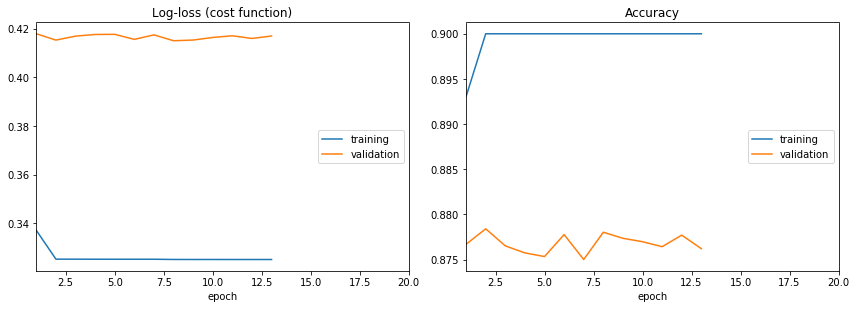

Epoch 14/20
1561/1562 [============================>.] - ETA: 0s - loss: 0.3251 - acc: 0.9000

KeyboardInterrupt: 

In [22]:
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
              epochs=20, steps_per_epoch=x_train.shape[0] // batch_size,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks = callbacks)